In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import manada
import lenstronomy as ls

ls.laconic()
root_path = manada.__path__[0][:-7]

### Load catalog

In [14]:
# Look for cosmo catalog in the default path
cosmos_folder = root_path + '/datasets/cosmos/COSMOS_23.5_training_sample'

catalog = manada.Sources.cosmos.COSMOSCatalog(cosmos_folder, cosmology='planck18')

Retrieving image sizes: 100%|██████████| 57/57 [01:16<00:00,  1.35s/it]


### Image plotting function

In [23]:
test= catalog.iter_lightmodel_kwargs_samples(5)
type(test)

generator

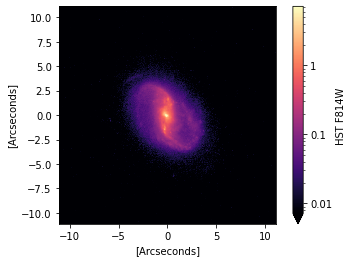

In [15]:
# Just a nice galaxy image for testing the plot
nice_galaxy_i = 20451

PIXEL_LENGTH = manada.Sources.cosmos.HUBBLE_ACS_PIXEL_WIDTH

def grid_for(img, x0=0, y0=0, edges=True):
    nx, ny = img.shape
    dx = nx * PIXEL_LENGTH
    dy = nx * PIXEL_LENGTH
    extra = 1 if edges else 0
    x = np.linspace(-dx/2, dx/2, nx + extra) + x0
    y = np.linspace(-dy/2, dy/2, ny + extra) + y0
    return x, y

def show_image(img, vmin=None, **kwargs):
    vmax = img.max()
    if vmin is None:
        vmin = vmax * 1e-3    
    plt.pcolormesh(
        *grid_for(img),
        img.clip(vmin, None).T, 
        norm=matplotlib.colors.LogNorm(
            vmin=vmin, vmax=vmax
        ),
        **{**{'cmap': plt.cm.magma}, 
           **kwargs})
    plt.gca().set_aspect('equal')
    
    cbar = plt.colorbar(label='HST F814W', extend='min')
    
    # Fix colorbar ticks
    cax = cbar.ax
    # Use normal formatting
    cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
    if len(cbar.get_ticks()) < 2:
        # If there are very few ticks, show minor ticks too
        cax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
        cax.tick_params(axis='y', labelsize=7, which='minor')
        
    plt.xlabel("[Arcseconds]")
    plt.ylabel("[Arcseconds]")
    
show_image(catalog.image_and_metadata(nice_galaxy_i)[0])

### Lenstronomy setup

Setup all the different models

In [16]:
lens_model = ls.LensModel_(['SPEP'])
light_model = ls.LightModel_(['INTERPOL'])

n_pixels = 200
pixel_size = PIXEL_LENGTH

image_model = ls.ImageModel(
    data_class=ls.ImageData(**ls.data_configure_simple(
        numPix=n_pixels,
        deltaPix=pixel_size)),
    psf_class=ls.Data.psf.PSF(
        psf_type='GAUSSIAN', 
        # Very good seeing...
        fwhm=0.1 * PIXEL_LENGTH),
    lens_model_class=lens_model,
    source_model_class=light_model,
)

## Pass through an image without lensing

0.35530000925064087

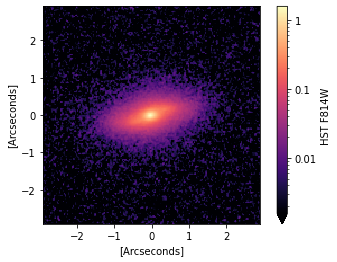

In [17]:
catalog_i = 44542
source_image = catalog.image_and_metadata(catalog_i)[0]

show_image(source_image)

z_old = catalog.catalog[catalog_i]['z']
z_old

/Users/sebwagner/Documents/Grad_School/Research/lenstronomy/lenstronomy/LensModel/Profiles/spep.py:78: RuntimeWarning: divide by zero encountered in true_divide
  fac = 1./eta*(a/(E*E))**(eta/2-1)*2


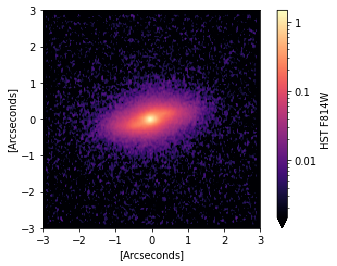

In [18]:
# !!! Without this, changes in image arguments will not take effect!
light_model.delete_interpol_caches()

lens_kwargs = [{'theta_E': 0.0, 'e1': 0., 'e2': 0., 'gamma': 0., 'center_x': 0, 'center_y': 0}]
source_kwargs = [catalog.lightmodel_kwargs(catalog_i=catalog_i, z_new=z_old)]

image = image_model.image(
    kwargs_lens=lens_kwargs, 
    kwargs_source=source_kwargs)

show_image(image)

Indeed, it looks like we are passing the image through without changing the scale / units.